In [1]:
from os import chdir
chdir('..')

In [2]:
# import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.relational import _LinePlotter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib notebook
sns.set(font_scale=1.1)
current_palette = sns.color_palette()

In [3]:
df = pd.read_csv('./test_fixtures/results/all_timings.csv')
df = df.replace('migloveholes', 'miglove')
df = df.replace('hiholes', 'hi')
df_all_section = df[df.section == 'all']
df_all_poly_cgal = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal'])]
df_all_poly_cgal_spatialite = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal', 'spatialite'])]
df_pl = df[df.alg == 'polylidar']
df_pl_sec = df_pl[df_pl.section != 'all']
df.head()

,alg,holes,l2_norm,points,section,shape,time
0,polylidar,True,NaN,4000,delaunay,hi,1.806
1,polylidar,True,NaN,4000,delaunay,hi,1.599
2,polylidar,True,NaN,4000,delaunay,hi,1.636
3,polylidar,True,NaN,4000,delaunay,hi,1.976
4,polylidar,True,NaN,4000,delaunay,hi,1.615


In [4]:
# # fig = plt.Figure()
# g = sns.relplot(x="points", y="time", hue="alg", style='holes',
#             facet_kws=dict(sharex=True, legend_out=False),col="shape",
#             kind="line", legend='brief', data=df_all_section,
#             height=4, aspect=1.5)
# g.set_ylabels("time (ms)")
# g.set_xlabels("# Points")
# # g.ax.legend(loc=2)
# # g.despine(left=True)
# # plt.legend(loc='upper left')
# g.savefig('assets/pics/compare_algs_time.pdf')
# # g.set(yscale="log")

In [5]:
# df_all_poly_cgal = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal'])]

# g = sns.relplot(x="points", y="time", hue="alg", style='holes',
#             facet_kws=dict(sharex=True, legend_out=True),col="shape",
#             kind="line", legend=False, data=df_all_poly_cgal,
#             height=2, aspect=2.5)
# g.set_ylabels("time (ms)")
# g.set_xlabels("# Points")
# # g.ax.legend(loc=2)
# # g.despine(left=True)
# # plt.legend(loc='upper left')
# g.savefig('assets/pics/compare_algs_time_poly_cgal.pdf')

In [4]:
def add_proper_legend(p, ax):
    p.legend='brief'
    p.add_legend_data(ax)
    legend_data = dict(p.legend_data)
    # Delete the parts of the legend we dont want
    for to_del in [True, False, 'alg', 'holes']:
        del legend_data[to_del]
    # Create the legend
    labels, handles = list(zip(*legend_data.items()))
    ax.legend(handles, labels)

def plot_time(df, df_inset, inset_axes=(0.75,0.35,.3,.25), inset_limits=(50000, 64000, 0, 500)):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
             sort=True, err_style="band", err_kws=None)
    
    palette = {'polylidar': current_palette[0], 'cgal': current_palette[1], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="time", hue="alg", style='holes',legend='brief', data=df, palette=palette, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    # Hacky way to create the legend that we want
    # have seaborn get the artist handles
    add_proper_legend(p, ax)


    ax.set_ylabel("time (ms)")
    ax.set_xlabel("# Points")
    ax.set_title('')
    # ax = g.facet_axis(0,0)
    ax.set_xlim([0, 70000])

    # Add inset zoomed in axes
    axins = ax.inset_axes(inset_axes)
    # axins = zoomed_inset_axes(ax,1.0,loc=1) # zoom=6
    x1,x2,y1,y2 = inset_limits
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)
    axins.set_xticks([])
    axins.set_yticks([0, 200, 400])
    axins.yaxis.tick_right()

    mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.3")
    sns.lineplot(x='points', y='time', hue='alg', style='holes', legend=False, data=df_inset, ax=axins)
    axins.set_xlabel('')
    axins.set_ylabel('')
    for spine in axins.spines.values():
        spine.set_edgecolor('0.3')
        
def plot_error(df, y_lim=[0, 0.12]):
    line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
                        sort=True, err_style="band", err_kws=None)
    palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

    p = _LinePlotter(x="points", y="l2_norm", hue="alg", style='holes', palette=palette, legend=False, data=df, **line_kwargs)
    ax = plt.gca()
    p.plot(ax, {})
    add_proper_legend(p, ax)

    ax.set_title('')
    ax.set_ylabel(r'$L^2$ error')
    ax.set_xlabel("# Points")
    ax.set_ylim(y_lim)

    

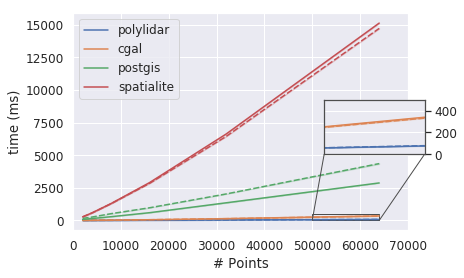

In [5]:
plt.close(plt.gcf())
df_mi = df_all_section[df_all_section['shape'].isin(['miglove'])]
df_mi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['miglove'])]
plot_time(df_mi, df_all_poly_cgal)

plt.savefig('assets/pics/compare_algs_time_inset_mi.pdf', bbox_inches='tight')

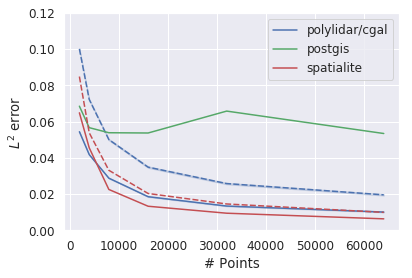

In [6]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_mi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal)

plt.savefig('assets/pics/compare_algs_accuracy_mi.pdf', bbox_inches='tight')
# g.set(yscale="log")

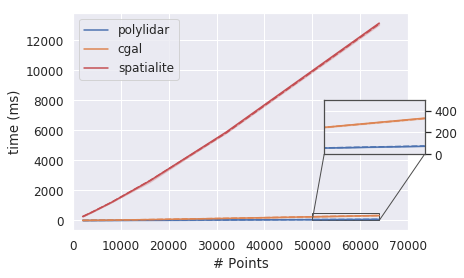

In [7]:
plt.close(plt.gcf())
df_hi = df_all_poly_cgal_spatialite[df_all_poly_cgal_spatialite['shape'].isin(['hi'])]
df_hi_poly_cgal = df_all_poly_cgal[df_all_poly_cgal['shape'].isin(['hi'])]
plot_time(df_hi, df_hi)

plt.savefig('assets/pics/compare_algs_time_inset_hi.pdf', bbox_inches='tight')

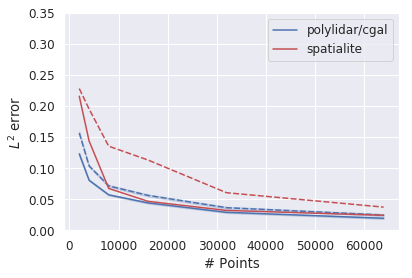

In [8]:
plt.close(plt.gcf())
df_all_section_comb_poly_cgal =  df_hi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

plot_error(df_all_section_comb_poly_cgal, y_lim=[0, 0.350])

plt.savefig('assets/pics/compare_algs_accuracy_hi.pdf', bbox_inches='tight')

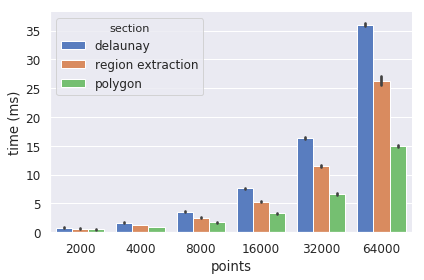

In [9]:
fig = plt.Figure((5,5))
df_pl_sec = df_pl_sec.replace('mesh', 'region extraction')
g = sns.catplot(x="points", y="time", hue="section", data=df_pl_sec, kind="bar", palette="muted",
                hue_order=["delaunay", "region extraction", "polygon"],  height=4, aspect=1.5, legend_out=False)

g.set_ylabels("time (ms)")
g.savefig('assets/pics/polylidar_decomposed.pdf')
# g.set(yscale="log")
# g.savefig("imgs/timing_results.pdf")

In [12]:
df_pl_sec_miglove = df_pl_sec[df_pl_sec['shape'] == 'miglove']

df_new = df_pl_sec_miglove.groupby([df_pl_sec_miglove['section'], df_pl_sec_miglove['points']]).mean()
df_new = df_new.reset_index()
df_delaunay = df_new[df_new['section'] == 'delaunay']
df_mesh = df_new[df_new['section'] == 'mesh']
df_polygon = df_new[df_new['section'] == 'polygon']

delaunay_diff = df_delaunay['time'].pct_change().reset_index()
mesh_diff = df_mesh['time'].pct_change().reset_index()
polygon_diff = df_polygon['time'].pct_change().reset_index()

values = []
names = ['delaunay_PctChange', 'mesh_PctChange', 'polygon_PctChange']
values.append(delaunay_diff.values[1:,1])
values.append(mesh_diff.values[1:, 1])
values.append(polygon_diff.values[1:, 1])

pd.DataFrame.from_items(zip(names, values))



/home/jeremy/miniconda3/envs/concave/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
